# Assembly name prediction

Index:
- Simple baseline with BERT and cosine similarity
- Fine-tuned BERT
- CLIP-like contrastive pretraining

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy.linalg import norm
from transformers import BertTokenizer, TFBertModel, TFAutoModel
from keras import layers
from numba import cuda
import tensorflow_addons as tfa

## Simple baseline with BERT and cosine similarity

### Pre-process data for task

In [2]:
data_path = "../data/data_02.feather"
data = pd.read_feather(data_path)

In [3]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id", 'assembly_description'])
data.head()

,assembly_name,part_names
0,Lava Lamp 2,"[Blob3, Blob2, Blob1, Glass, Cap]"
1,Sample - Headphones,"[Pivot hinge, Headphone hinge, Telescope hinge..."
4,Coffee Mug,"[Mug, Lid]"
5,Dave's Handsome Mug,"[Lid, Seal, Vessel]"
9,Mechanical Pencil,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod..."


In [4]:
# Deduplicate
print(f"Tot: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"\nAfter dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot: 88886
Unique: 67834

After dedup: 61725
Unique: 54034


### Clean assembly names

In [5]:
def process_assembly_names(string):
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.STP', '')
    string = string.replace('.STEP', '')
    string = string.replace('.zip', '')
    string = string.replace('.ZIP', '')
    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_assembly_names(row.assembly_name), axis=1)

In [6]:
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49601


### Clean part names

In [7]:
def process_part_names(list):
    part_names = []
    for string in list:
        if "MANIFOLD_SOLID_BREP" in string:
            return np.nan
        string = string.replace('.x_t', '')
        string = string.replace('.stp', '')
        string = string.replace('.step', '')
        string = string.replace('.dwg', '')
        string = string.replace('.zip', '')
        string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
        string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
        string = string.lower()
        string = string.replace('_', ' ')
        string = string.replace('-', ' ')
        string = string.replace('[', ' ')
        string = string.replace(']', ' ')
        string = string.replace('(', ' ')
        string = string.replace(')', ' ')
        string = string.replace('?', ' ')
        string = string.replace('*', ' ')
        string = string.replace('copy of', ' ')
        string = string.replace('copy', ' ')
        string = " ".join(string.split())

        part_names.append(string)

    return part_names


data['part_names_clean'] = data.apply(lambda row: process_part_names(row.part_names), axis=1)
data.dropna(subset=['part_names_clean'], inplace=True)


In [8]:
data.head()

,assembly_name,part_names,assembly_name_clean,part_names_clean
0,Lava Lamp 2,"[Blob3, Blob2, Blob1, Glass, Cap]",lava lamp 2,"[blob, blob, blob, glass, cap]"
1,Sample - Headphones,"[Pivot hinge, Headphone hinge, Telescope hinge...",sample headphones,"[pivot hinge, headphone hinge, telescope hinge..."
4,Coffee Mug,"[Mug, Lid]",coffee mug,"[mug, lid]"
5,Dave's Handsome Mug,"[Lid, Seal, Vessel]",dave's handsome mug,"[lid, seal, vessel]"
9,Mechanical Pencil,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod...",mechanical pencil,"[eraser, pencil lead, rubber grip, gripper rod..."


### Create sentences for BERT

In [9]:
def create_sentences(data_df, deduplicate_part_names=True):
    part_name_sentences = []
    assembly_name_sentences = []

    for index, row in data_df.iterrows():
        # if len(row['part_names_clean']) > 1:
        # build single part name sentence
        part_name_sentence = "An assembly containing the following parts: "
        if deduplicate_part_names:
            part_names = set(row['part_names_clean'])
        else:
            part_names = row['part_names_clean']
        for part_name in part_names:
            part_name_sentence +=  f"{part_name}, "
        part_name_sentence = part_name_sentence[:-2] + "."
        part_name_sentences.append(part_name_sentence)

        # build single assembly name sentence
        assembly_name_sentence = f"An assembly with the name '{row['assembly_name_clean']}'"
        assembly_name_sentences.append(assembly_name_sentence)
    return part_name_sentences, assembly_name_sentences

In [10]:
part_name_sentences, assembly_name_sentences = create_sentences(data)

In [11]:
print(len(part_name_sentences))
part_name_sentences[:10]

61601


['An assembly containing the following parts: blob, cap, glass.',
 'An assembly containing the following parts: upper band, telescope hinge, headphone speaker, pivot hinge, headphone hinge.',
 'An assembly containing the following parts: mug, lid.',
 'An assembly containing the following parts: vessel, lid, seal.',
 'An assembly containing the following parts: rubber grip, eraser, gripper rod, button release, pencil lead, lead gripper.',
 'An assembly containing the following parts: peg, block, plate, link, wheel.',
 'An assembly containing the following parts: torch holder, default, head, b18.3.5m 4 x 0.7 x 10 socket fchs 10s.',
 'An assembly containing the following parts: bottle base, cap.',
 'An assembly containing the following parts: x2 00e9 x0 crou m axe corps levier, goupille axe levier, symmetry of piston, vis bouton gauche, supports levier, tank, axes molette levier, symmetry of x2 00e9 x0 crou m axe corps levier, rondelle clips, human head, btr m, human fore arm, symmetry of

In [12]:
print(len(assembly_name_sentences))
assembly_name_sentences[:10]

61601


["An assembly with the name 'lava lamp 2'",
 "An assembly with the name 'sample headphones'",
 "An assembly with the name 'coffee mug'",
 "An assembly with the name 'dave's handsome mug'",
 "An assembly with the name 'mechanical pencil'",
 "An assembly with the name 'os kinematics'",
 "An assembly with the name 'torch light for bike'",
 "An assembly with the name 'bottle'",
 "An assembly with the name 'concept vehicle'",
 "An assembly with the name 'mounting arm'"]

### Train test split

In [13]:
test_data = pd.read_csv('../data/test.csv')

In [14]:
test_strings, test_labels = create_sentences(data.loc[test_data['Unnamed: 0'].tolist()])

In [15]:
test_strings[:5]

['An assembly containing the following parts: end 2, long divider, short divider, side 1, side 2, end 1.',
 'An assembly containing the following parts: 20mm stack.',
 'An assembly containing the following parts: boxlid, internalcomb, mainbox, windholder, barform, basebottomkeyhalf, basebottomkeyotherhalf, basetopkey.',
 'An assembly containing the following parts: timming pulley 20t g2, delrin v wheel, carrage mount prt8, shape, extruder body alumium, timming pulley 16t g2, wheel a1, m3cerated nut, new plate, turbine, heater, 184, 156, l 2112kk ir, 174, 151, glass bed, solid, motor shaft, 158, bed center, 182, 180, heater block^e3d nozzle v, rail cross part, 176, frame b4, 178, boden lever arm, vt1m3x30, l 2112kk cage, 150, 177, v slot 20x60x500 linear rail, spacer 5x10x6.35, 181, z screw, pneumatic con m, 148, 144, aluminum spacer 6mm, aluminum spacer 9mm, 172, carriage mount 2 prt10, l 2112kk shield, nut driver prt3, 160, 169, frame b3, pivot pin, heater block, l 2112kk ball, lead s

In [16]:
test_labels[:5]

["An assembly with the name 'box shell version'",
 "An assembly with the name '20mm stack'",
 "An assembly with the name 'ww sport base bar box'",
 "An assembly with the name 'circle builder'",
 "An assembly with the name '2238 375.step'"]

In [17]:
train_data = pd.read_csv('../data/train.csv')

In [18]:
train_strings, train_labels = create_sentences(data.loc[train_data['Unnamed: 0'].tolist()])

In [19]:
train_strings[:5]

['An assembly containing the following parts: 27135t32.',
 'An assembly containing the following parts: cheminement, atteinte poignee, chaudiere, sortie sec, baignoire, porte chaudiere, plat pow, pot 4, ouverture porte chaud, cabine salle attent, ouverture porte lpg, porte toilettes, paroie cab 1, chaise bureau, ergometer x, faut sal att, toilettes, \\x2\\00e9\\x0\\tag\\x2\\00e8\\x0\\re, lpg, armoire lpg, porte toi 1, lavabo, porte bain, cercle manoeuvre, table mass fixe, elec coffret, paroie bureau toilettes, batiment, pot 2, engin reeduc, ouverture porte toi 1, porte lpg, toilette, chair, ouverture porte 2, pot 1, machine laver, porte entr\\x2\\00e9\\x0\\e, meuble rang bureau, batiment 210616, table mass regl, tapis kettler track 9, multi fitness center, satura eext, paroie cab 2.',
 'An assembly containing the following parts: runlarger small insert.',
 'An assembly containing the following parts: entaniya fisheye.',
 'An assembly containing the following parts: hdr 1x4t 2.54 10x2, 

In [20]:
train_labels[:5]

["An assembly with the name 'mh 50 assembly'",
 "An assembly with the name '20160612 local complet'",
 "An assembly with the name 'runlarger small insert'",
 "An assembly with the name 'overview one mark v'",
 "An assembly with the name 'battery case'"]

In [21]:
print(f"Length of train strings: {len(train_strings)}")
print(f"Length of train labels: {len(train_labels)}")
print(f"Length of test strings: {len(test_strings)}")
print(f"Length of test labels: {len(test_labels)}")

Length of train strings: 49280
Length of train labels: 49280
Length of test strings: 12321
Length of test labels: 12321


### Tokenize and create embeddings

In [24]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
def create_embeddings(strings, labels, tokenizer, model, max_length=128, batch_size=100, pooling='cls'):

    test_strings_embeddings_batched, test_labels_embeddings_batched = [], []
    num_batches = len(strings)//batch_size
    for batch in tqdm(range(num_batches), total=num_batches):
        test_strings_token = tokenizer(strings[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True, # TODO: check the dimensions and whether it needs to be 'max_length'
                      return_tensors='tf')

        test_labels_tokens = tokenizer(labels[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True, # TODO: check the dimensions and whether it needs to be 'max_length'
                      return_tensors='tf')

        test_strings_embeddings = model(test_strings_token)
        test_labels_embeddings = model(test_labels_tokens)

        if pooling == 'cls':
            test_strings_embeddings = test_strings_embeddings[0][:, 0, :]
            test_labels_embeddings = test_labels_embeddings[0][:, 0, :]
        else:
            test_strings_embeddings = test_strings_embeddings[1]
            test_labels_embeddings = test_labels_embeddings[1]
        test_strings_embeddings_batched.append(test_strings_embeddings)
        test_labels_embeddings_batched.append(test_labels_embeddings)

    return test_strings_embeddings_batched, test_labels_embeddings_batched

In [25]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer, bert_model)

100%|██████████| 123/123 [01:35<00:00,  1.29it/s]


### Evaluate with cosine similarity and argmax

In [26]:
def evaluate_similarity(test_strings_embeddings_batches, test_labels_embeddings_batches, axis=0):
    similarity_batches = []
    for batch_id in range(len(test_strings_embeddings_batches)):
        test_strings_embeddings = tf.nn.l2_normalize(test_strings_embeddings_batches[batch_id], axis)
        test_labels_embeddings = tf.nn.l2_normalize(test_labels_embeddings_batches[batch_id], axis)

        similarity = test_strings_embeddings @ tf.transpose(test_labels_embeddings)
        similarity_batches.append(similarity)

    return similarity_batches

In [26]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

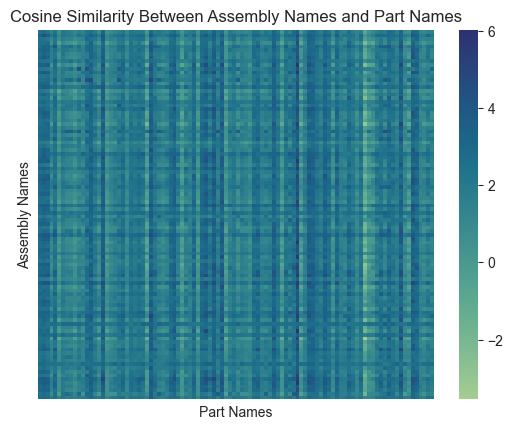

In [27]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [28]:
pred = []
true = []
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    pred.append(predicted)
    true.append(actual)
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 16 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 91 | Actual: 4
Predicted: 28 | Actual: 5
Predicted: 94 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [29]:
def evaluate_accuracy(similarity_batches):
    top_ks = [1,5,10]
    for k in top_ks:
        tot_accuracy = []
        for batch in similarity_batches:
            top_k_values = np.argsort(-batch, axis=1)[:,:k]
            correct = 0
            for index, row in enumerate(top_k_values):
                if index in row:
                    correct += 1
            accuracy = correct / len(batch)
            tot_accuracy.append(accuracy)


        print(f"Top-{k} accuracy: {np.mean(tot_accuracy)}")

In [30]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.05739837398373985
Top-5 accuracy: 0.15691056910569107
Top-10 accuracy: 0.23902439024390246


## Fine-tuned BERT

### Load fine-tuned model from checkpoint and get embeddings

In [31]:
checkpoint_dir = 'fine_tuning/bert_fine_tuned_2'
bert_tokenizer_2 = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model_2 = TFBertModel.from_pretrained(checkpoint_dir)

Some layers from the model checkpoint at fine_tuning/bert_fine_tuned_2 were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at fine_tuning/bert_fine_tuned_2 and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer_2, bert_model_2)

100%|██████████| 123/123 [01:33<00:00,  1.31it/s]


### Evaluate

In [35]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

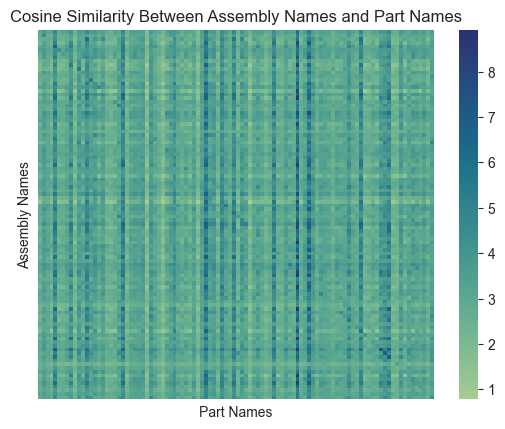

In [36]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [37]:
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 12 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 4 | Actual: 4
Predicted: 65 | Actual: 5
Predicted: 65 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [38]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.09536585365853659
Top-5 accuracy: 0.20902439024390246
Top-10 accuracy: 0.3039024390243903


## CLIP-like Contrastive Pre-training
The code for the dual encoder model was adapted from [this example](https://keras.io/examples/nlp/nl_image_search/).

### Pre-process test data and create data loader for training data
We are implementing the batched data-loader as described in [the notebook provided](https://github.com/datasci-w266/2022-fall-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb).

In [36]:
train_data_path = '../data/train.csv'

In [34]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [32]:
def preprocess_data(raw_data, wanted_data, tokenizer, max_length=128):
    part_name_sentences, assembly_name_sentences = create_sentences(raw_data.loc[wanted_data['Unnamed: 0'].tolist()])

    parts_tokens = tokenizer(part_name_sentences,
                  max_length=max_length,
                  truncation=True,
                  padding='max_length',
                  return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    part_input_ids = np.array(parts_tokens["input_ids"], dtype="int32")
    part_attention_masks = np.array(parts_tokens["attention_mask"], dtype="int32")
    part_token_type_ids = np.array(parts_tokens["token_type_ids"], dtype="int32")

    assemblies_tokens = tokenizer(assembly_name_sentences,
                  max_length=max_length,
                  truncation=True,
                  padding='max_length',
                  return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    assembly_input_ids = np.array(assemblies_tokens["input_ids"], dtype="int32")
    assembly_attention_masks = np.array(assemblies_tokens["attention_mask"], dtype="int32")
    assembly_token_type_ids = np.array(assemblies_tokens["token_type_ids"], dtype="int32")

    features = {
        'assembly_inputs': [part_input_ids, part_attention_masks, part_token_type_ids],
        'part_inputs': [assembly_input_ids, assembly_attention_masks, assembly_token_type_ids]
    }

    return features

In [33]:
class DataGeneratorFromFile(tf.keras.utils.Sequence):
    def __init__(self,
                 tokenizer,
                 n_examples,
                 data_filename,
                 max_length=128,
                 batch_size=100,
                 shuffle=True):

        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()

    def __len__(self):
        return self.n_examples // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        train_data_df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)

        batch_data = preprocess_data(
            data,
            train_data_df,
            self.tokenizer,
            self.max_length
        )

        return batch_data

    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [34]:
test_data_preprocessed = preprocess_data(data, test_data, tokenizer=bert_tokenizer, max_length=128)

## Build Model

In [29]:
# Implement the text encoder
def create_text_encoder(train_layers=5, bert_model_name='bert-base-uncased', max_length=128, pool_token='cls', attention=False, fully_connected_layers=None):
    bert_model = TFAutoModel.from_pretrained(bert_model_name)

    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    else:
        bert_model.trainable = True
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
        print('retrain layers: ', retrain_layers)
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                # print('freezing: ', w.name)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    if attention:
        print("using attention layer")
        output = bert_out.last_hidden_state
        attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=100)(output, output)
        max_pool = layers.GlobalMaxPooling1D()(attn_output)
        dropout_output = layers.Dropout(0.3)(max_pool)
        output = layers.Dense(512, activation="relu")(dropout_output)
    else:
        if pool_token == 'pool':
            print("Using pool")
            output = bert_out[1]
        elif pool_token == 'cls':
            print("Using cls")
            output = bert_out[0][:, 0, :]
        else:
            raise Exception(f"Output not supported: {pool_token}")

    if fully_connected_layers is not None:
        print("Adding fully connected layers")
        for i in range(fully_connected_layers - 1):
            output = tf.keras.layers.Dense(768, activation='tanh', name=f'hidden_layer_{i}')(output)
            output = tf.keras.layers.Dropout(0.2)(output)

        output = tf.keras.layers.Dense(768, activation='tanh', name=f'hidden_layer_last')(output)   # TODO: try activation=None, 768 dimensions
        # output = tf.keras.layers.Dropout(0.3)(output)

    model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[output], name='text_encoder')
    return model

In [30]:
# Implement the dual encoder
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, inputs, training=False):
        assembly_inputs, part_inputs = inputs['assembly_inputs'], inputs['part_inputs']
        assembly_embeddings = self.text_encoder(assembly_inputs, training=training)
        parts_embeddings = self.text_encoder(part_inputs, training=training)

        return assembly_embeddings, parts_embeddings

    def compute_loss(self, assembly_embeddings, parts_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(assembly_embeddings, parts_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        parts_similarity = tf.matmul(
            parts_embeddings, parts_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        assembly_similarity = tf.matmul(
            assembly_embeddings, assembly_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (parts_similarity + assembly_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        assembly_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        parts_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (assembly_loss + parts_loss) / 2

    def train_step(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        with tf.GradientTape() as tape:
            # Forward pass
            assembly_embeddings, parts_embeddings = self(inputs, training=True)
            loss = self.compute_loss(assembly_embeddings, parts_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        assembly_embeddings, parts_embeddings = self(inputs, training=False)
        loss = self.compute_loss(assembly_embeddings, parts_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [67]:
# Train the dual encoder model
num_epochs = 30  # In practice, train for at least 30 epochs
train_layers = 1
temperature = 0.05
pool_out = 'cls'

text_encoder = create_text_encoder(train_layers=train_layers, max_length=128)
dual_encoder = DualEncoder(text_encoder, temperature=temperature)
dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
Using cls


In [68]:
train_data_generator = DataGeneratorFromFile(
    tokenizer=bert_tokenizer,
    n_examples=len(pd.read_csv(train_data_path)),
    data_filename=train_data_path,
    batch_size=100
)

# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = dual_encoder.fit(
    train_data_generator,
    epochs=num_epochs,
    validation_data=test_data_preprocessed,
    callbacks=[reduce_lr , early_stopping],
)
print("Training completed. Saving text encoder...")
text_encoder.save(f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}")
print("Models are saved.")

Epoch 1/30


492/492 [==============================] - 600s 1s/step - loss: 19.7616 - val_loss: 2.6872 - lr: 0.0010
Epoch 2/30
492/492 [==============================] - 597s 1s/step - loss: 4.3430 - val_loss: 2.5197 - lr: 0.0010
Epoch 3/30
492/492 [==============================] - 599s 1s/step - loss: 3.8538 - val_loss: 2.5191 - lr: 0.0010
Epoch 4/30
492/492 [==============================] - 597s 1s/step - loss: 3.6637 - val_loss: 2.4483 - lr: 0.0010
Epoch 5/30
492/492 [==============================] - 592s 1s/step - loss: 3.5466 - val_loss: 2.3175 - lr: 0.0010
Epoch 6/30
492/492 [==============================] - 592s 1s/step - loss: 3.4378 - val_loss: 2.2672 - lr: 0.0010
Epoch 7/30
492/492 [==============================] - 594s 1s/step - loss: 3.3766 - val_loss: 2.2587 - lr: 0.0010
Epoch 8/30
492/492 [==============================] - 594s 1s/step - loss: 3.3325 - val_loss: 2.2283 - lr: 0.0010
Epoch 9/30
492/492 [==============================] - 594s 1s/step - loss: 3.2757 - val_loss: 2.22

INFO:tensorflow:Assets written to: text_encoder_30_1_cls_0.05\assets


INFO:tensorflow:Assets written to: text_encoder_30_1_cls_0.05\assets


Models are saved.


In [27]:
def visualize_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

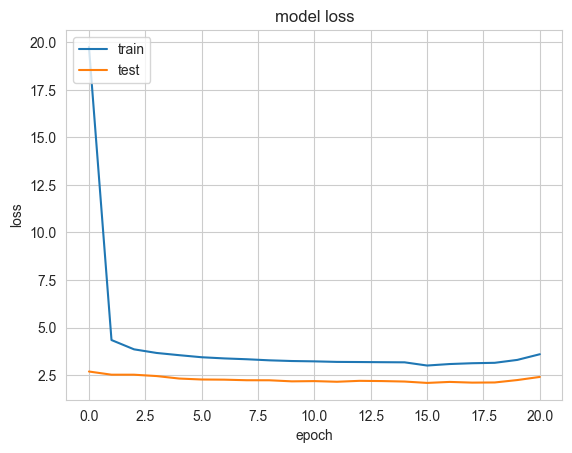

In [70]:
visualize_history(history)

## Evaluate retrieval quality
To evaluate the dual encoder model, we use the captions as queries. We use the out-of-training-sample images and captions to evaluate the retrieval quality, using top k accuracy. A true prediction is counted if, for a given caption, its associated image is retrieved within the top k matches.

In [71]:
# Load text encoder
text_encoder = keras.models.load_model(f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}")

In [72]:
# Generate embeddings for the test data
test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

386/386 [==============================] - 73s 189ms/step


In [73]:
# batch the embeddings into sets of 100
batch_size = 100
test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

In [74]:
similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

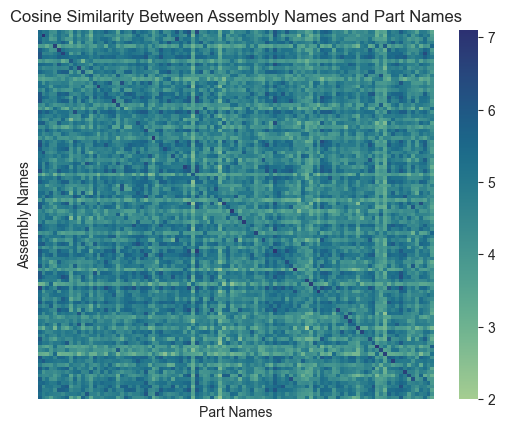

In [105]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [76]:
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 40 | Actual: 0
Predicted: 1 | Actual: 1
Predicted: 35 | Actual: 2
Predicted: 33 | Actual: 3
Predicted: 4 | Actual: 4
Predicted: 5 | Actual: 5
Predicted: 6 | Actual: 6
Predicted: 0 | Actual: 7
Predicted: 8 | Actual: 8
Predicted: 60 | Actual: 9


In [77]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.38568220236657813
Top-5 accuracy: 0.5525444739595912
Top-10 accuracy: 0.6316091121307251


## Hyperparam search




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.05, 'cls', False, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
Using cls
Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                    

492/492 [==============================] - 588s 1s/step - loss: 27.2507 - val_loss: 3.3145 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 596s 1s/step - loss: 4.9582 - val_loss: 3.1661 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 596s 1s/step - loss: 4.1995 - val_loss: 2.8071 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 598s 1s/step - loss: 3.8653 - val_loss: 2.6406 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 598s 1s/step - loss: 3.7075 - val_loss: 2.5218 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.05_False_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.05_False_None\assets


Model is saved: text_encoder_5_1_cls_0.05_False_None.


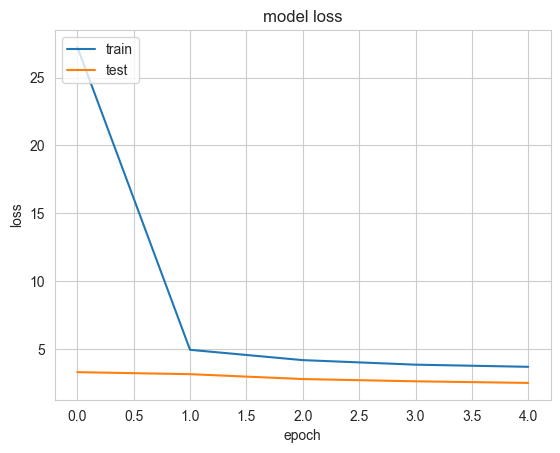

386/386 [==============================] - 72s 186ms/step
Top-1 accuracy: 0.2599645818240361
Top-5 accuracy: 0.4461595427835466
Top-10 accuracy: 0.5407059486436447


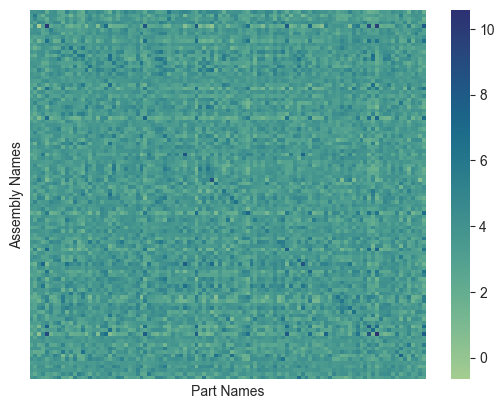




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.04, 'cls', False, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
Using cls
Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                    

492/492 [==============================] - 619s 1s/step - loss: 25.6814 - val_loss: 2.9320 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 599s 1s/step - loss: 4.8668 - val_loss: 2.9091 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 598s 1s/step - loss: 4.1502 - val_loss: 2.7834 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 598s 1s/step - loss: 3.8769 - val_loss: 2.6411 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 596s 1s/step - loss: 3.7242 - val_loss: 2.5240 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.04_False_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.04_False_None\assets


Model is saved: text_encoder_5_1_cls_0.04_False_None.


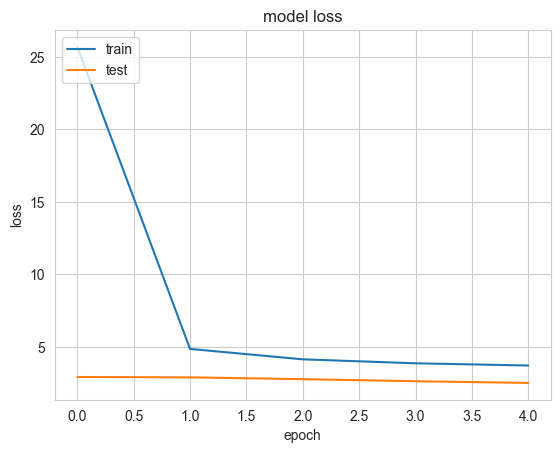

386/386 [==============================] - 72s 185ms/step
Top-1 accuracy: 0.24623762376237626
Top-5 accuracy: 0.43810351766884
Top-10 accuracy: 0.5351758834420027


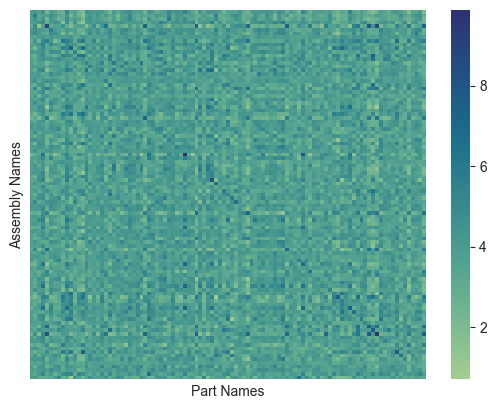




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.06, 'cls', False, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
Using cls
Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                    

492/492 [==============================] - 613s 1s/step - loss: 14.3856 - val_loss: 2.4492 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 597s 1s/step - loss: 3.9414 - val_loss: 2.3501 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 597s 1s/step - loss: 3.6746 - val_loss: 2.3490 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 597s 1s/step - loss: 3.5202 - val_loss: 2.2995 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 591s 1s/step - loss: 3.4273 - val_loss: 2.2586 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.06_False_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.06_False_None\assets


Model is saved: text_encoder_5_1_cls_0.06_False_None.


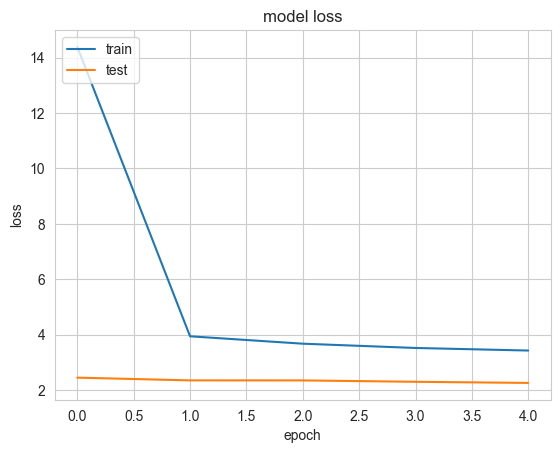

386/386 [==============================] - 70s 182ms/step
Top-1 accuracy: 0.322961442485712
Top-5 accuracy: 0.496963696369637
Top-10 accuracy: 0.5893342992835868


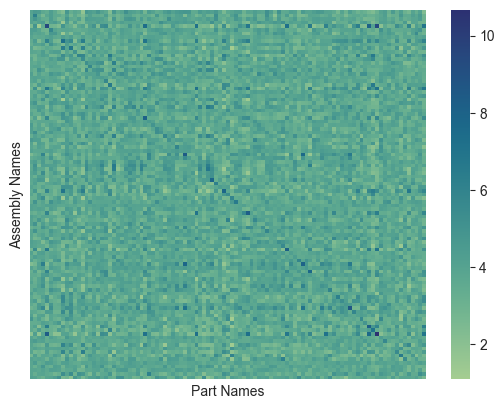




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.05, 'pool', False, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
Using pool
Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                   

492/492 [==============================] - 610s 1s/step - loss: 181.7051 - val_loss: 7.8017 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 592s 1s/step - loss: 86.9743 - val_loss: 3.9722 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 590s 1s/step - loss: 100.7886 - val_loss: 4.5687 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 590s 1s/step - loss: 97.0680 - val_loss: 11.0889 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 593s 1s/step - loss: 105.6910 - val_loss: 3.8105 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.05_False_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.05_False_None\assets


Model is saved: text_encoder_5_1_pool_0.05_False_None.


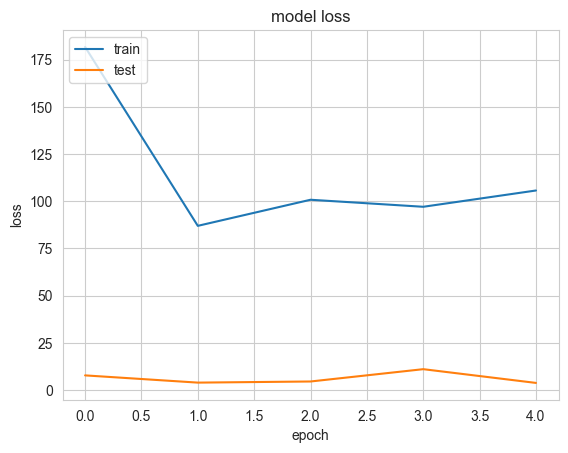

386/386 [==============================] - 74s 191ms/step
Top-1 accuracy: 0.010064396683570795
Top-5 accuracy: 0.04983337358126057
Top-10 accuracy: 0.09999356033164293


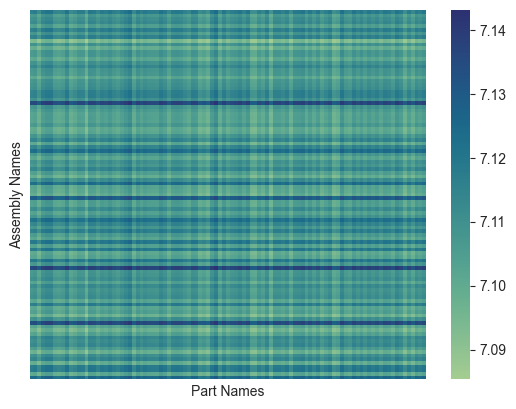




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.04, 'pool', False, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
Using pool
Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                   

492/492 [==============================] - 619s 1s/step - loss: 58.1884 - val_loss: 6.4921 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 597s 1s/step - loss: 40.6262 - val_loss: 4.0169 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 597s 1s/step - loss: 56.3584 - val_loss: 13.7598 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 596s 1s/step - loss: 52.3120 - val_loss: 3.4913 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 596s 1s/step - loss: 7.9078 - val_loss: 3.4657 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.04_False_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.04_False_None\assets


Model is saved: text_encoder_5_1_pool_0.04_False_None.


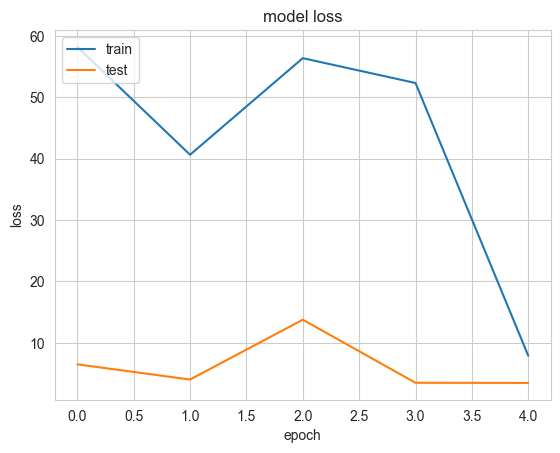

386/386 [==============================] - 73s 189ms/step
Top-1 accuracy: 0.010226998309587058
Top-5 accuracy: 0.05032037350076471
Top-10 accuracy: 0.09974965789261854


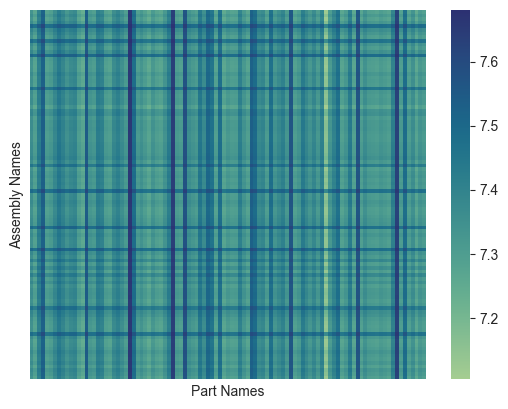




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.06, 'pool', False, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
Using pool
Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                   

492/492 [==============================] - 615s 1s/step - loss: 337.1002 - val_loss: 4.3161 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 595s 1s/step - loss: 99.4957 - val_loss: 5.1253 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 593s 1s/step - loss: 71.1038 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 588s 1s/step - loss: 5.2157 - val_loss: 3.4661 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 587s 1s/step - loss: 4.6868 - val_loss: 3.4709 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.06_False_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_pool_0.06_False_None\assets


Model is saved: text_encoder_5_1_pool_0.06_False_None.


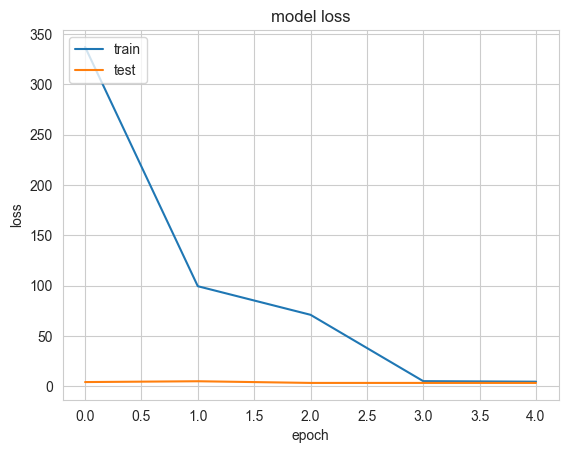

386/386 [==============================] - 71s 184ms/step
Top-1 accuracy: 0.010631087498993802
Top-5 accuracy: 0.055100217338807066
Top-10 accuracy: 0.10932785961522982


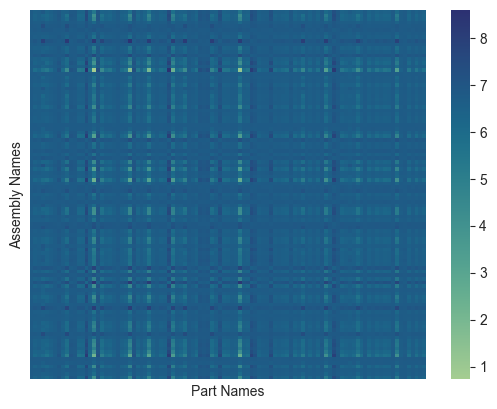

In [49]:
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [
           [5, 1, 0.05, 'cls', False, None],
           [5, 1, 0.04, 'cls', False, None],
           [5, 1, 0.06, 'cls', False, None],
           [5, 1, 0.05, 'pool', False, None],
           [5, 1, 0.04, 'pool', False, None],
           [5, 1, 0.06, 'pool', False, None],

           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    text_encoder.summary()
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr] #, early_stopping],
    )
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)

    ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
    ax.set(xlabel="Part Names", ylabel="Assembly Names") #, title="Cosine Similarity Between Assembly Names and Part Names")
    plt.show()

## Network architecture search




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 1, 0.05, 'cls', True, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 622s 1s/step - loss: 5.0802 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 621s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 622s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 623s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 623s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 2.0000e-04
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.05_True_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_1_cls_0.05_True_None\assets


Model is saved: text_encoder_5_1_cls_0.05_True_None.


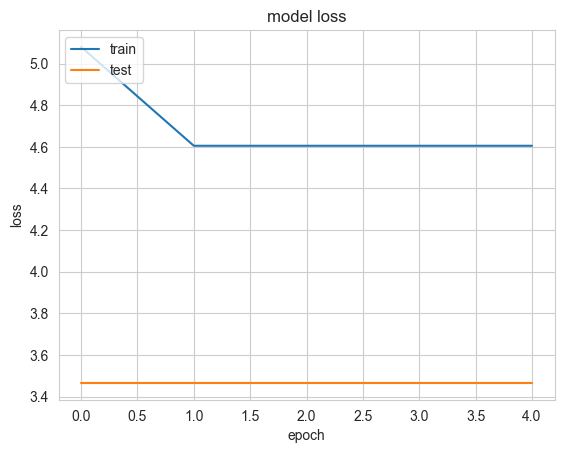

386/386 [==============================] - 73s 190ms/step
Top-1 accuracy: 0.009740803348627548
Top-5 accuracy: 0.049426869516219926
Top-10 accuracy: 0.09666183691539887


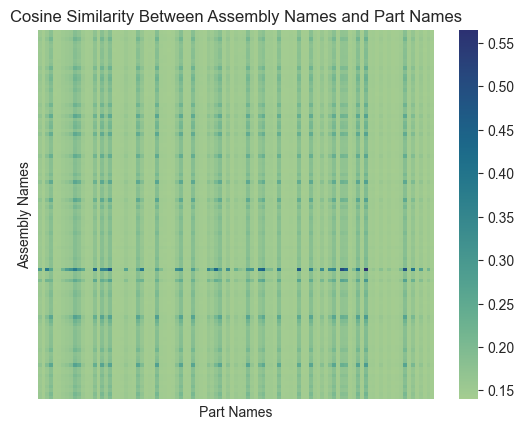




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 1]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_1\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_1\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_1.


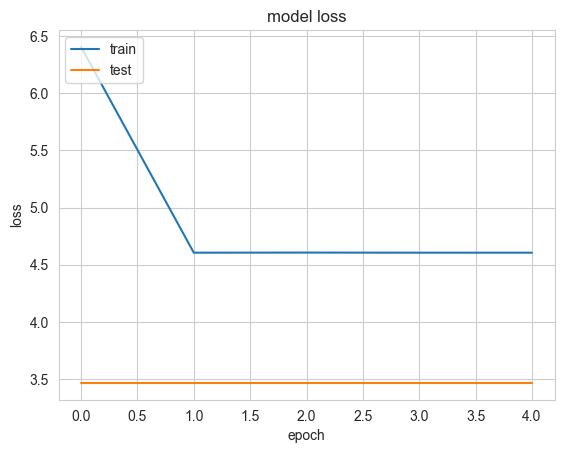

386/386 [==============================] - 72s 187ms/step
Top-1 accuracy: 0.009983095870562666
Top-5 accuracy: 0.04991547935281333
Top-10 accuracy: 0.09983095870562667


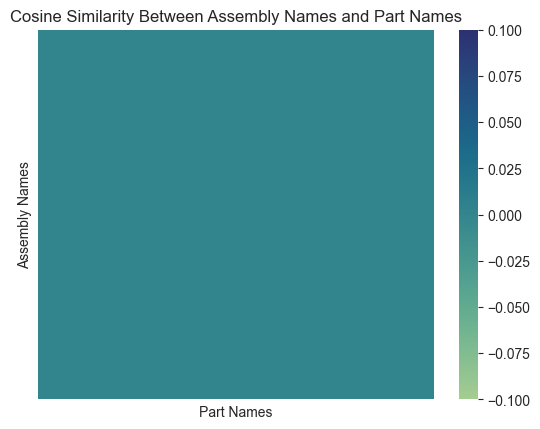




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 2]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_2\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_2\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_2.


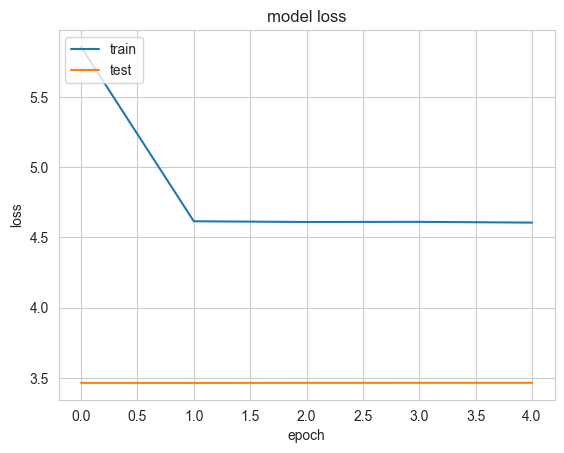

386/386 [==============================] - 72s 185ms/step
Top-1 accuracy: 0.009983095870562666
Top-5 accuracy: 0.04991547935281333
Top-10 accuracy: 0.09983095870562667


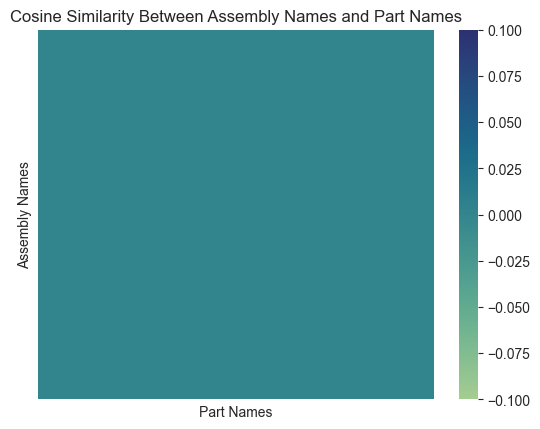




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 3]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_3\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_3\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_3.


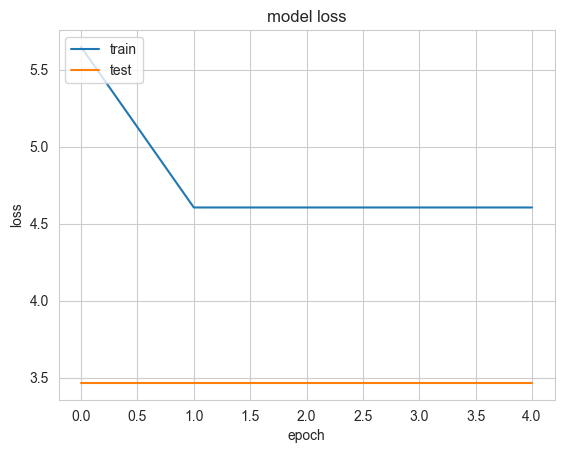

386/386 [==============================] - 71s 185ms/step
Top-1 accuracy: 0.010146502455123559
Top-5 accuracy: 0.05007808097882959
Top-10 accuracy: 0.1013700394429687


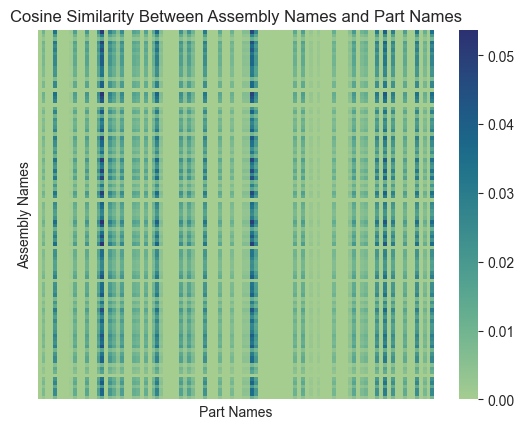




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 4]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_4\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_4\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_4.


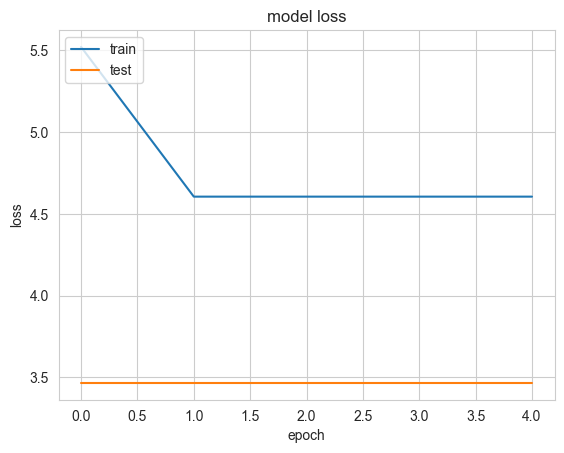

386/386 [==============================] - 73s 189ms/step
Top-1 accuracy: 0.009900990099009901
Top-5 accuracy: 0.05015857683329309
Top-10 accuracy: 0.10064316187716334


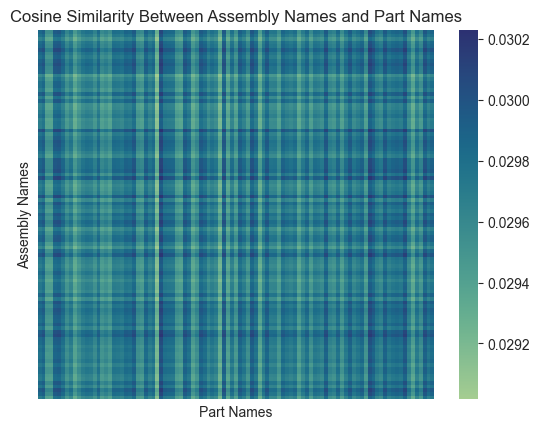




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 5]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_5\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_5\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_5.


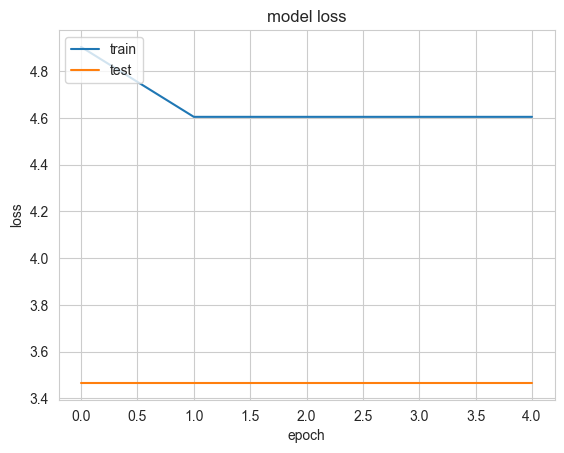

386/386 [==============================] - 73s 188ms/step
Top-1 accuracy: 0.009983095870562666
Top-5 accuracy: 0.04975287772679707
Top-10 accuracy: 0.09991225951863479


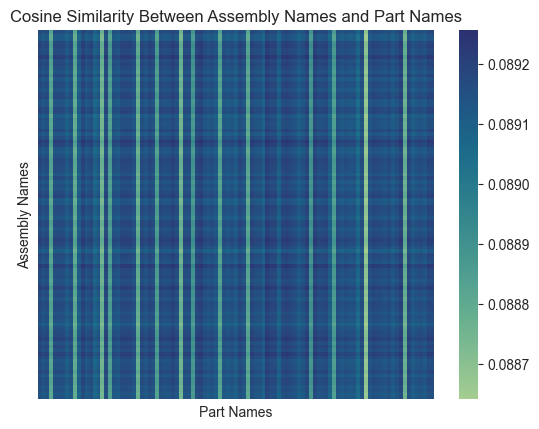




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 6]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_6\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_6\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_6.


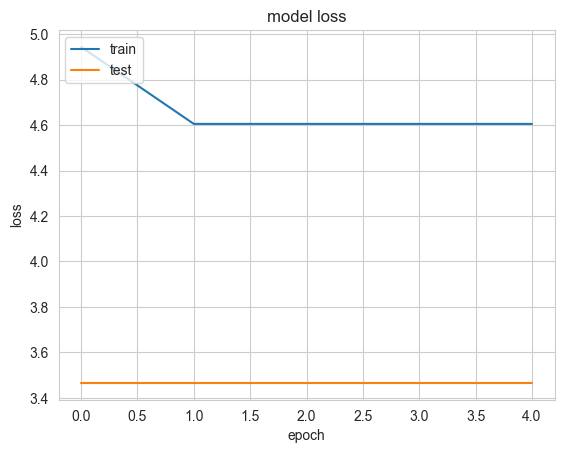

386/386 [==============================] - 73s 189ms/step
Top-1 accuracy: 0.010064396683570793
Top-5 accuracy: 0.049995975207276826
Top-10 accuracy: 0.09983095870562667


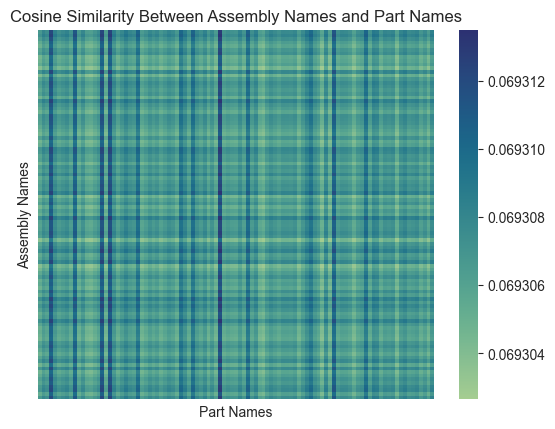




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 7]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_7\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_7\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_7.


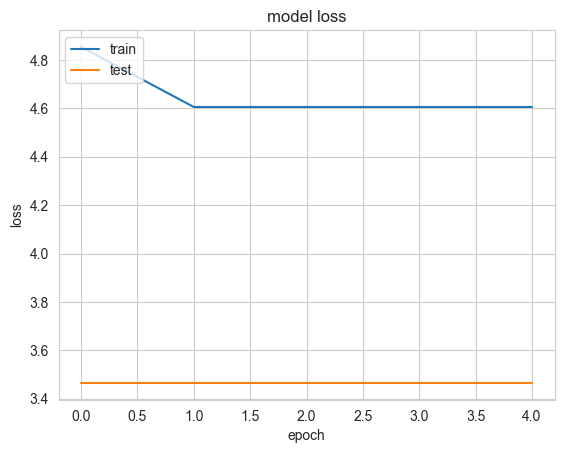

386/386 [==============================] - 73s 189ms/step
Top-1 accuracy: 0.010544956934717862
Top-5 accuracy: 0.05080495854463496
Top-10 accuracy: 0.10088142960637529


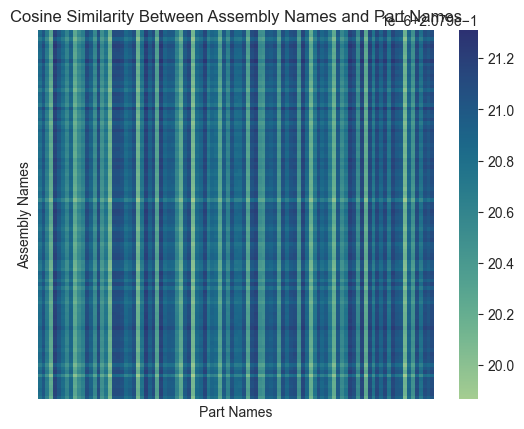




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, -1, 0.05, 'cls', False, 8]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_8\assets


INFO:tensorflow:Assets written to: text_encoder_5_-1_cls_0.05_False_8\assets


Model is saved: text_encoder_5_-1_cls_0.05_False_8.


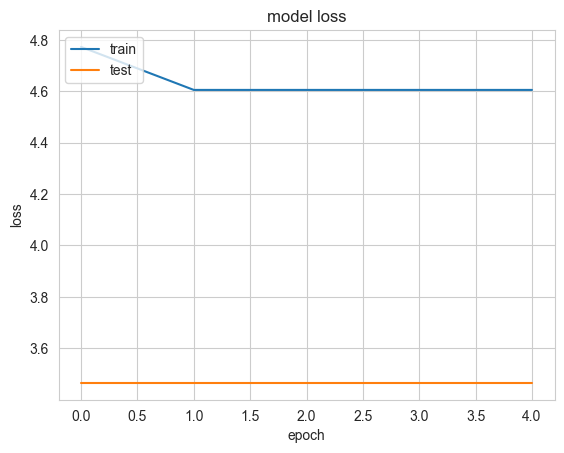

386/386 [==============================] - 75s 194ms/step
Top-1 accuracy: 0.010222973516863881
Top-5 accuracy: 0.04959430089350398
Top-10 accuracy: 0.1007252676487161


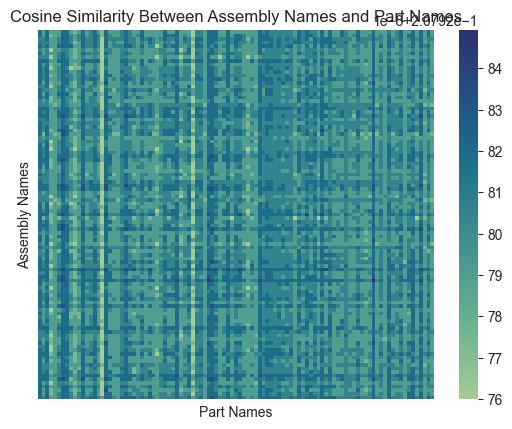

In [47]:
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [
            [5, 1, 0.05, 'cls', True, None],
           [5, -1, 0.05, 'cls', False, 1],
           [5, -1, 0.05, 'cls', False, 2],
           [5, -1, 0.05, 'cls', False, 3],
           [5, -1, 0.05, 'cls', False, 4],
           [5, -1, 0.05, 'cls', False, 5],
           [5, -1, 0.05, 'cls', False, 6],
           [5, -1, 0.05, 'cls', False, 7],
           [5, -1, 0.05, 'cls', False, 8],
           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    text_encoder.summary()
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr] # , early_stopping],
    )
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)

    ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
    ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")
    plt.show()




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', True, None]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 714s 1s/step - loss: 5.2737 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 688s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 686s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 686s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_True_None\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_True_None\assets


Model is saved: text_encoder_5_2_cls_0.05_True_None.


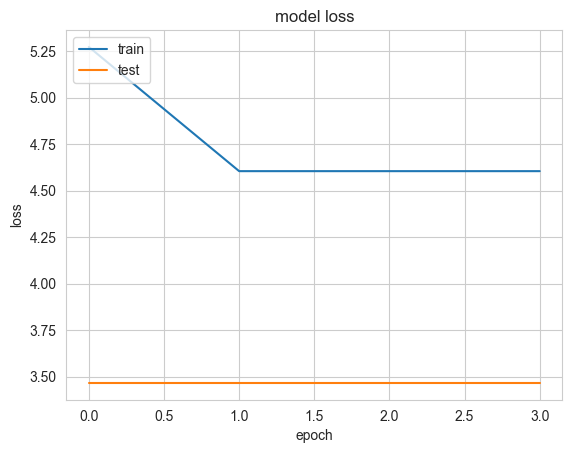

386/386 [==============================] - 74s 191ms/step
Top-1 accuracy: 0.01006359172502616
Top-5 accuracy: 0.049996780165821465
Top-10 accuracy: 0.10015535699911456


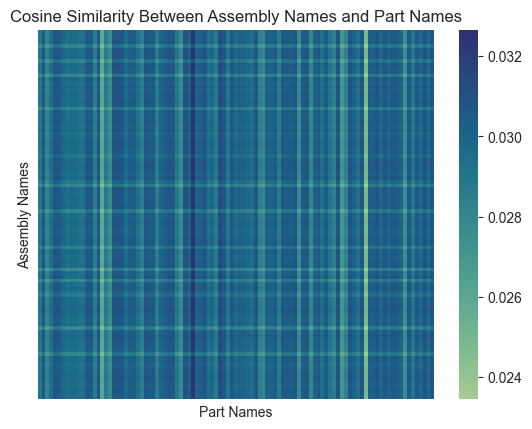




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 1]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 671s 1s/step - loss: 7.1937 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 652s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_1\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_1\assets


Model is saved: text_encoder_5_2_cls_0.05_False_1.


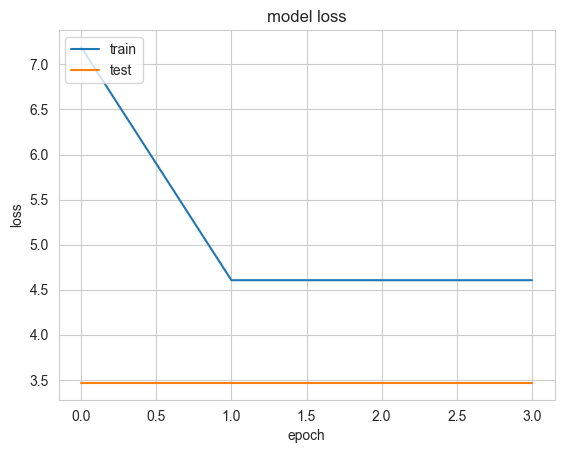

386/386 [==============================] - 74s 192ms/step
Top-1 accuracy: 0.009983095870562666
Top-5 accuracy: 0.04991547935281333
Top-10 accuracy: 0.09983095870562667


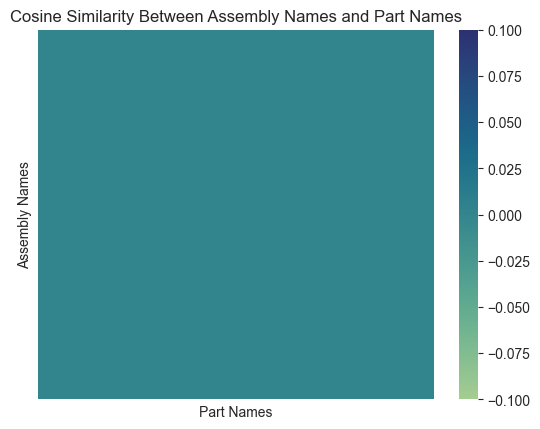




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 2]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 677s 1s/step - loss: 6.4644 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 655s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 653s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 654s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_2\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_2\assets


Model is saved: text_encoder_5_2_cls_0.05_False_2.


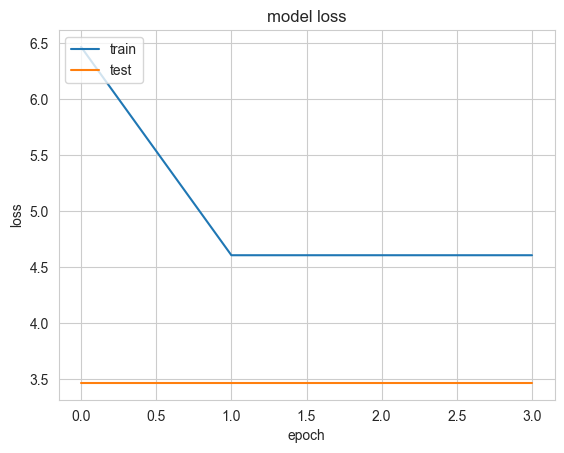

386/386 [==============================] - 74s 192ms/step
Top-1 accuracy: 0.011527811317717136
Top-5 accuracy: 0.05665137245431861
Top-10 accuracy: 0.10908717701038398


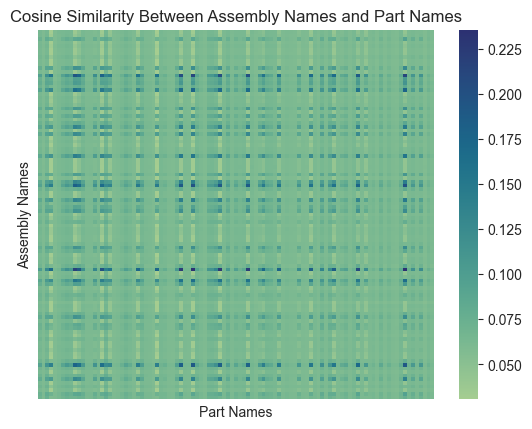




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 3]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 676s 1s/step - loss: 6.7989 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 649s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_3\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_3\assets


Model is saved: text_encoder_5_2_cls_0.05_False_3.


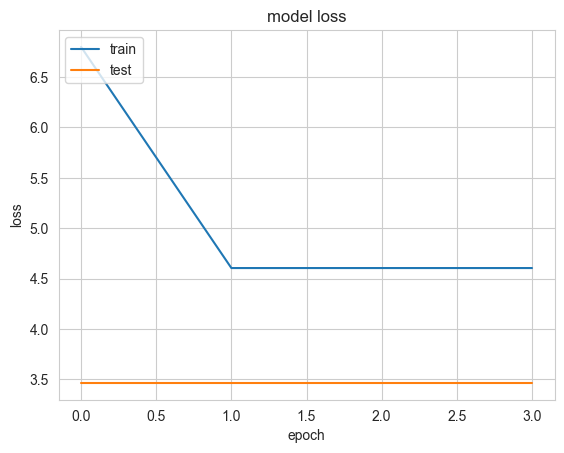

386/386 [==============================] - 73s 188ms/step
Top-1 accuracy: 0.011683973275376318
Top-5 accuracy: 0.060380745391612346
Top-10 accuracy: 0.11826048458504386


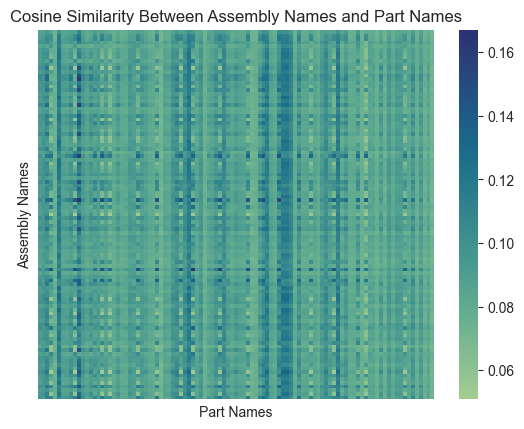




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 4]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 673s 1s/step - loss: 5.3854 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 650s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 653s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 655s 1s/step - loss: 4.6052 - val_loss: 3.4655 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_4\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_4\assets


Model is saved: text_encoder_5_2_cls_0.05_False_4.


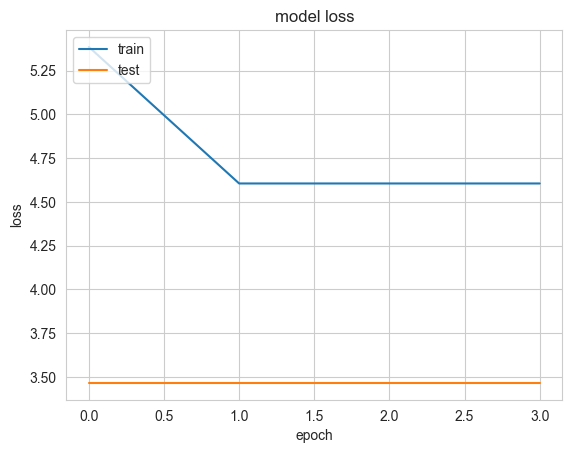

386/386 [==============================] - 74s 192ms/step
Top-1 accuracy: 0.008439990340497465
Top-5 accuracy: 0.04691137406423569
Top-10 accuracy: 0.09471947194719472


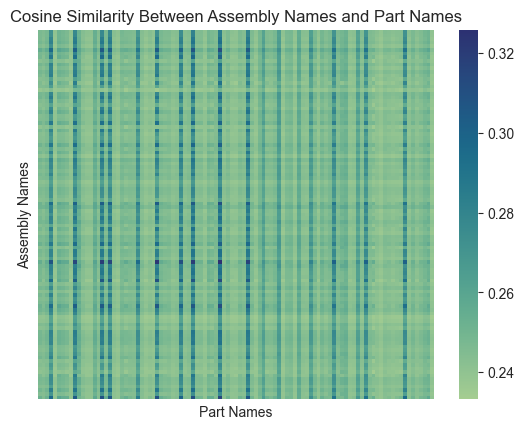

In [48]:
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [
           [5, 2, 0.05, 'cls', True, None],
           [5, 2, 0.05, 'cls', False, 1],
           [5, 2, 0.05, 'cls', False, 2],
           [5, 2, 0.05, 'cls', False, 3],
           [5, 2, 0.05, 'cls', False, 4],
           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    text_encoder.summary()
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr, early_stopping],
    )
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)

    ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
    ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")
    plt.show()




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 1]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_1\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_1\assets


Model is saved: text_encoder_5_2_cls_0.05_False_1.


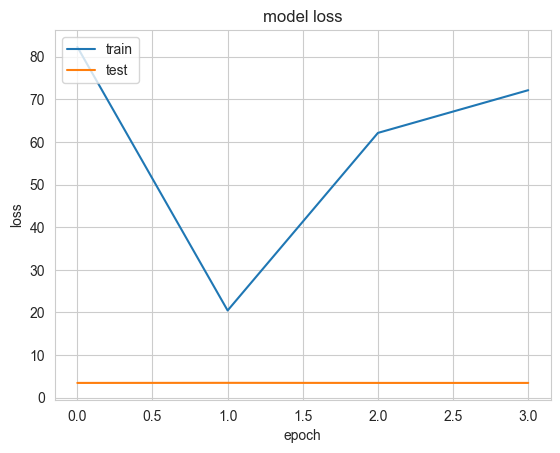

386/386 [==============================] - 70s 181ms/step
Top-1 accuracy: 0.010064396683570793
Top-5 accuracy: 0.04942767447476456
Top-10 accuracy: 0.09974724301698464


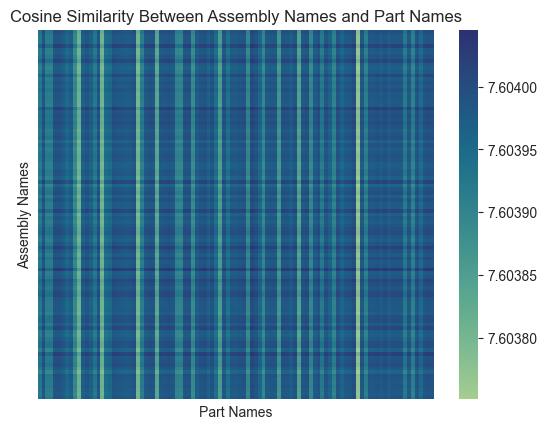




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 2]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 666s 1s/step - loss: 52.2374 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 646s 1s/step - loss: 5.5060 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 648s 1s/step - loss: 5.9957 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 650s 1s/step - loss: 6.2846 - val_loss: 3.4658 - lr: 0.0010
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_2\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_2\assets


Model is saved: text_encoder_5_2_cls_0.05_False_2.


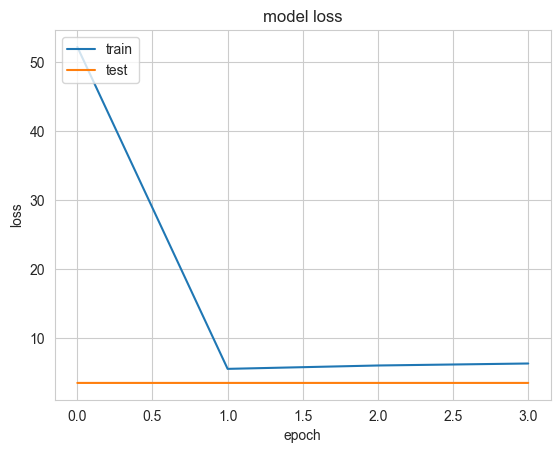

386/386 [==============================] - 72s 186ms/step
Top-1 accuracy: 0.009901795057554534
Top-5 accuracy: 0.051867503823553096
Top-10 accuracy: 0.10178298317636642


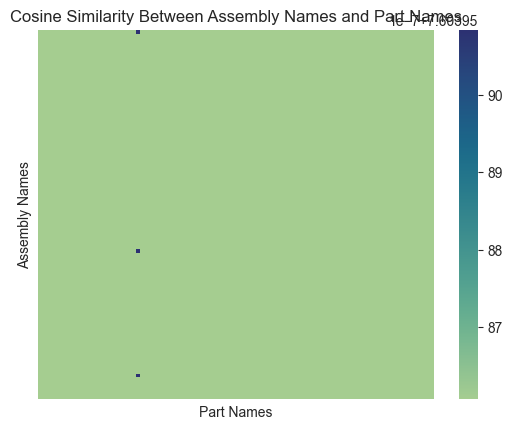




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 3]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 672s 1s/step - loss: 24.2534 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 652s 1s/step - loss: 5.3367 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 653s 1s/step - loss: 38.5191 - val_loss: 3.4741 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 653s 1s/step - loss: 4.8781 - val_loss: 3.4733 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 652s 1s/step - loss: 7.5531 - val_loss: 3.5211 - lr: 2.0000e-04
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_3\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_3\assets


Model is saved: text_encoder_5_2_cls_0.05_False_3.


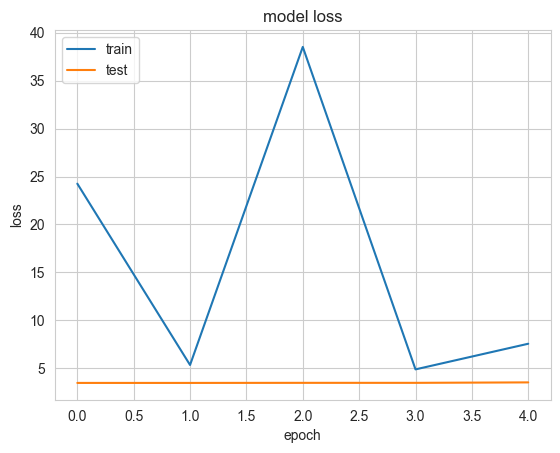

386/386 [==============================] - 72s 186ms/step
Top-1 accuracy: 0.009414795138050392
Top-5 accuracy: 0.04950656041213877
Top-10 accuracy: 0.09772116236013846


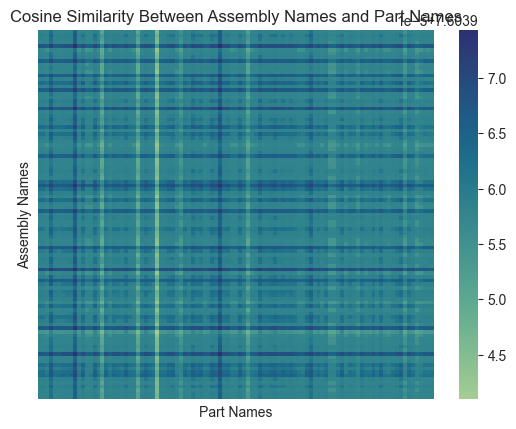




num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
[5, 2, 0.05, 'cls', False, 4]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                       

492/492 [==============================] - 677s 1s/step - loss: 24.1293 - val_loss: 3.4655 - lr: 0.0010
Epoch 2/5
492/492 [==============================] - 651s 1s/step - loss: 5.2813 - val_loss: 3.4655 - lr: 0.0010
Epoch 3/5
492/492 [==============================] - 651s 1s/step - loss: 18.2337 - val_loss: 3.4655 - lr: 0.0010
Epoch 4/5
492/492 [==============================] - 650s 1s/step - loss: 4.9110 - val_loss: 3.4655 - lr: 0.0010
Epoch 5/5
492/492 [==============================] - 650s 1s/step - loss: 6.7095 - val_loss: 3.4655 - lr: 2.0000e-04
Training completed. Saving text encoder...


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_4\assets


INFO:tensorflow:Assets written to: text_encoder_5_2_cls_0.05_False_4\assets


Model is saved: text_encoder_5_2_cls_0.05_False_4.


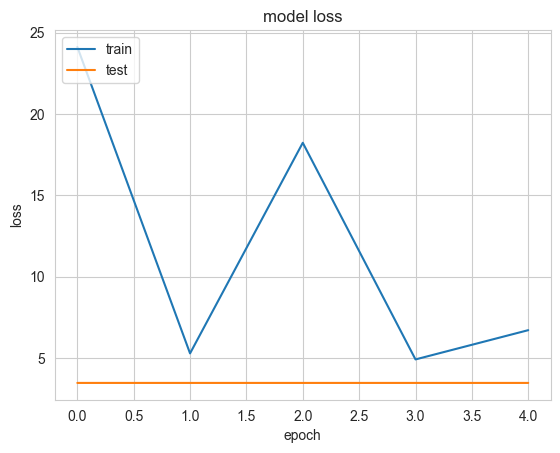

386/386 [==============================] - 71s 183ms/step
Top-1 accuracy: 0.009012315865732916
Top-5 accuracy: 0.05008854543990985
Top-10 accuracy: 0.10260001609917091


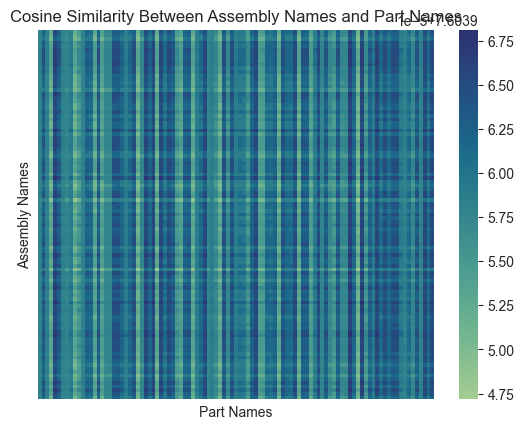

In [29]:
# after changing activation to tanh, and dropout to 0.2
# configs = num_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers
configs = [
           # [5, 2, 0.05, 'cls', False, None],
           [5, 2, 0.05, 'cls', False, 1],
           [5, 2, 0.05, 'cls', False, 2],
           [5, 2, 0.05, 'cls', False, 3],
           [5, 2, 0.05, 'cls', False, 4],
           ]

for config in configs:
    print("\n\n\nnum_epochs, train_layers, temperature, pool_out, attention, fully_connected_layers")
    print(config)
    # Train the dual encoder model
    num_epochs = config[0]
    train_layers = config[1]
    temperature = config[2]
    pool_out = config[3]
    attention = config[4]
    fully_connected_layers = config[5]

    text_encoder = create_text_encoder(train_layers=train_layers, max_length=128, pool_token=pool_out, attention=attention, fully_connected_layers=fully_connected_layers)
    dual_encoder = DualEncoder(text_encoder, temperature=temperature)
    dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

    train_data_generator = DataGeneratorFromFile(
        tokenizer=bert_tokenizer,
        n_examples=len(pd.read_csv(train_data_path)),
        data_filename=train_data_path,
        batch_size=100
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
    # Create an early stopping callback.
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    history = dual_encoder.fit(
        train_data_generator,
        epochs=num_epochs,
        validation_data=test_data_preprocessed,
        callbacks=[reduce_lr]#, early_stopping],
    )
    text_encoder.summary()
    print("Training completed. Saving text encoder...")
    model_name = f"text_encoder_{num_epochs}_{train_layers}_{pool_out}_{temperature}_{attention}_{fully_connected_layers}"
    text_encoder.save(model_name)
    print(f"Model is saved: {model_name}.")

    visualize_history(history)

    # Evaluate
    # Generate embeddings for the test data
    test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
    test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

    # batch the embeddings into sets of 100
    batch_size = 100
    test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
    test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

    similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)
    evaluate_accuracy(similarity_batches)

    ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
    ax.set(xlabel="Part Names", ylabel="Assembly Names") #, title="Cosine Similarity Between Assembly Names and Part Names")
    plt.show()

## Qualitative Evaluation

In [91]:
correct_examples = []
incorrect_examples = []

batch = similarity_batches[0]
k = 1
top_k_values = np.argsort(-batch, axis=1)[:,:k]
for index, row in enumerate(top_k_values):
    if index in row:
        # Correct example
        correct_examples.append([test_labels[index], test_strings[index]])
    else:
        # Incorrect example
        incorrect_examples.append([test_strings[index], test_labels[index] , test_labels[row[0]]])

print(f"Number of correct examples: {len(correct_examples)}")
print(f"Number of incorrect examples: {len(incorrect_examples)}")
print(f"Percentage of correct examples: {len(correct_examples) / (len(incorrect_examples) + len(correct_examples))}")

Number of correct examples: 43
Number of incorrect examples: 58
Percentage of correct examples: 0.42574257425742573


In [82]:
print("Correct examples:")
for example in correct_examples:
    print(example)

Correct examples:
["An assembly with the name '20mm stack'", 'An assembly containing the following parts: 20mm stack.']
["An assembly with the name '2238 375.step'", 'An assembly containing the following parts: 2238 375.']
["An assembly with the name 'sleeve'", 'An assembly containing the following parts: cap, sleeve.']
["An assembly with the name 'line holder'", 'An assembly containing the following parts: top line holder, bottom line holder, rod carrying tube, rod shaft.']
["An assembly with the name '11.78'", 'An assembly containing the following parts: 8 andr\\x2\\00e9\\x0\\ mouri\\x2\\00f1\\x0\\o fig11 78.']
["An assembly with the name 'ubicación guayacanes hermanos'", 'An assembly containing the following parts: tapa limaton opuesto 2, ubicaci\\x2\\00f3\\x0\\n villa luz google maps y levantamiento topografico 2, perfile limaton 2, correa cuartos, correa corta cuartos, tapa perfil limaton, perfile limaton, base columna 3.']
["An assembly with the name 'rod jigs'", 'An assembly con

In [103]:
print("Incorrect examples:")
for example in incorrect_examples:
    print(f"-Part names: {example[0][44:]}")
    print(f"-Ground truth: {example[1][26:]}")
    print(f"-Incorrect prediction{example[2][26:]}")
    print()

Incorrect examples:
-Part names: end 1, long divider, end 2, side 1, short divider, side 2.
-Ground truth: 'box shell version'
-Incorrect prediction'ufo'

-Part names: mainbox, boxlid, internalcomb, basebottomkeyotherhalf, windholder, barform, basebottomkeyhalf, basetopkey.
-Ground truth: 'ww sport base bar box'
-Incorrect prediction'bed frame'

-Part names: 171, motor shaft, vt3m4x12, rail cross part, bed rotor mount, 168, 151, base board, 170, 163, 176, build plate prt11, 182, z screw, 184, new plate, aluminum spacer 20mm, pin, extruder grove wheel\x2\00d8\x0\13, carriage mount 2 prt10, 166, l 2112kk cage, vt1m3x30, 144, 142, arm, pcb^endstop, 159, pneumatic con m, extruder bridge aluminium, 179, 178, teflon tube, frame b4, 148, heater block, steel tube, delrin v wheel, 146, heatsink^e3d nozzle v, 169, 161, 157, wheel a1, solid, 175, nut driver prt3, fitting, 156, turbine, spacer 5x10x6.35, 155, 154, wheel b1, 147, 180, 181, heater block^e3d nozzle v, 162, nozzle 0.3mm^e3d nozzle v, 